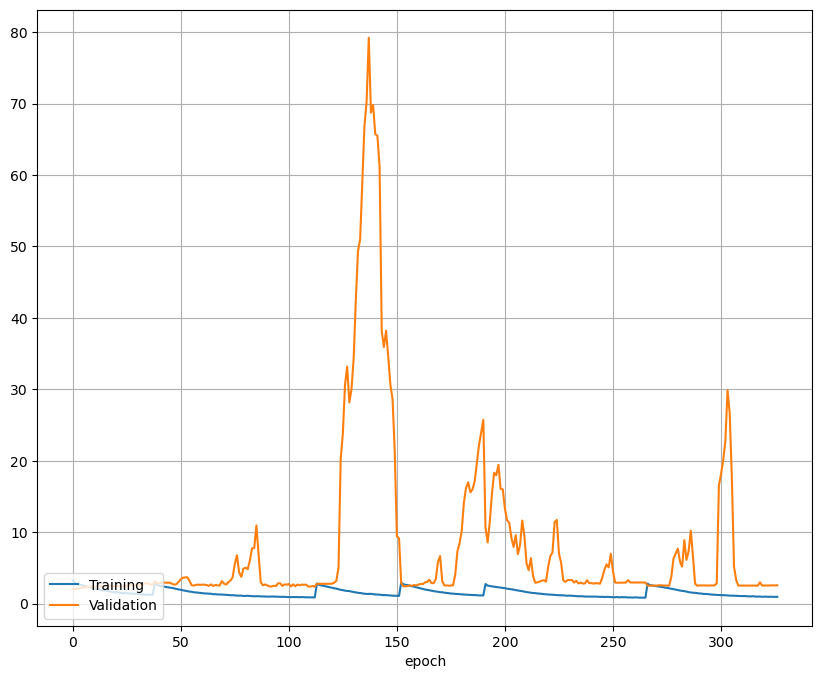

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import numpy as np

def live_plot(data_dict, figsize=(10,8), title=""):

    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='lower left') # the plot evolves to the right
    plt.show();

start=0

while True:
    try:
        mae = np.load("./models/mae.npy")[start:]
        val_mae = np.load("./models/val_mae.npy")[start:]
    except:
        continue
    live_plot({"Training": mae, "Validation": val_mae})
    sleep(.1)

# Training History

In [ ]:
# Hide annoying tensorflow outputs
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np

skip = 0

mae = np.load("./models/mae.npy")
val_mae = np.load("./models/val_mae.npy")

precision = np.load("./models/precision.npy")
val_precision = np.load("./models/val_precision.npy")

kl = np.load("./models/kl.npy")
val_kl = np.load("./models/val_kl.npy")

x_axis=np.arange(len(mae), step=1)

plt.rcParams["figure.figsize"] = (15, 6)
figure, axs = plt.subplots(3, 1, tight_layout=True)
figure.suptitle("Mean Absolute Error & Presision vs. Training Epoch")

axs[0].plot(mae, "blue", label="Loss")
axs[0].plot(val_mae, "orange", label="val Loss", alpha=.6)
axs[0].set_ylabel(r"$\overline{|\Delta z|}$")
axs[0].set_xticks(x_axis)
# if val_mae.size>0:
    # axs[0].set_yticks(np.arange(int(max(val_mae))+.1, step=1))
axs[0].legend(loc="upper center")
axs[0].grid()

axs[1].plot(precision, "orange", label="Presision")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel(r"$\frac{TP}{TP+FP}$")
# axs[1].set_xticks(x_axis)
axs[1].set_yticks(np.arange(1.2, step=0.2))
axs[1].legend(loc="upper center")
axs[1].grid()

axs[2].plot(kl, "red", label="KL Divergence")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel(r"$\frac{TP}{TP+FP}$")
# axs[2].set_xticks(x_axis)
# axs[2].set_yticks(np.arange(max(kl), step=5))
axs[2].legend(loc="upper center")
axs[2].grid()

plt.show()


# Load Model

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import pandas as pd
import numpy as np
import model

checkpoint = tf.train.latest_checkpoint("./models/")
nn = model.create_smaller_model(model.metrics)
nn.load_weights(checkpoint)


# Plot Predictions Function

In [ ]:
manga_wave = np.load("../manga_wave.npy")


def get_prediction_spectra(predictions: list):
    emission_lines = pd.DataFrame(
        [
            ["O2b", 3727.09, 1.78],
            ["O2a", 3729.88, 1.78],
            ["Hd", 4102.89, 1.52],
            ["Hc", 4341.68, 1.38],
            ["Hb", 4862.68, 1.13],
            ["O3b", 4960.30, 1.09],
            ["O3a", 5008.24, 1.07],
            ["N2b", 6549.86, 0.58],
            ["Ha", 6564.61, 0.58],
            ["N2a", 6585.27, 0.57],
            ["S2b", 6718.29, 0.54],
            ["S2a", 6732.68, 0.54],
        ],
        columns=["names", "wavelength", "zmax"],
    ).set_index("names")
    z = predictions[-1]
    snrs = predictions[0:-1]
    predicted_lines = np.zeros_like(manga_wave)
    for i, snr in enumerate(snrs):
        loc = (1 + z) * emission_lines.iloc[i].wavelength
        gaussian = np.sqrt(2 * np.pi) * 0.4 * norm.pdf(manga_wave, loc, 0.4) * snr
        predicted_lines += gaussian

    return predicted_lines


# Synthetic Spectra Predictions

In [ ]:
from sklearn.preprocessing import normalize

df = pd.read_parquet(
    "../1_data_generation/training_data/test_set/z_0.05203/Hb-Ha-N2a-S2b.parquet"
)

spectra = np.asarray([a.tolist() for a in df.spectra.values]).reshape(20, 4563)
labels = np.asarray(list(df.labels.values)).reshape(20, 13)

predictions = nn.predict(spectra)

idx = np.random.randint(len(spectra))
plt.rcParams["figure.figsize"] = (15, 3)
plt.title(predictions[idx])
plt.plot(manga_wave, spectra[idx])
plt.plot(manga_wave, np.round(get_prediction_spectra(predictions[idx]), 2), alpha=0.5)
plt.show()


# Poster Child Predictions

In [ ]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

all_zs = np.round(np.linspace(0.00370, 0.14970, 146), 5)
plt.rcParams["figure.figsize"] = (15, 3)
manga_wave = np.load("../manga_wave.npy")


rss_file = fits.open("../manga-8606-6102-LOGRSS.fits.gz")
specz_file = fits.open("../specz-8606-6102-LOGRSS.fits")


In [ ]:
models = specz_file["MODEL"].data
redshifts = specz_file["REDSHIFTS"].data["SPECZ"]
index_row = specz_file["REDSHIFTS"].data["INDEX_ROW"]
fluxs = rss_file["FLUX"].data
bin_numbers = np.digitize(redshifts, all_zs) - 1

backgrounds = []
for i, foreground in enumerate(models):
    flux = fluxs[index_row[i]]
    backgrounds.append(flux - foreground)

predictions = nn.predict(np.array(backgrounds))
print(len(predictions))


In [ ]:
idx = np.random.randint(len(backgrounds))
plt.title(predictions[idx])
plt.plot(manga_wave, backgrounds[idx])
plt.plot(manga_wave, get_prediction_spectra(predictions[0]))
plt.show()


# Post-prediction filter

1.) Single (O2) line or multi-line
    - Single line has O2 >= 6, multiline doesn't 
        - Gaussian O2 doublet SNR >=6 --> 
        - O2 doublet on top of sky line --> remove completely (known issue) PUT IN OVERLEAF
    - Multiline 2-5 emission lines >= 2
        - Does it have O3a & O3b --> what is the ratio? If not --> look at other lines
        - If not count number SNR > 4
            - 1 X
            - 2 B
            - 3 A-
            - 4 A
            - 5 A+

Graded with a hint --> +1/2

In [ ]:
# OIII could have SNR ratio of 3/1 b/a --> increase likelihood
#


def post_prediction_filter(lst: list):
    if len(lst) != 13:
        raise ValueError(
            f"Prediction list is not correct.\nIs length {len(lst)}, should be 13"
        )

    output = {}
    z = lst[-1]
    count = 0
    for i, snr in enumerate(lst[0:-1]):
        output[model.all_names[i]] = np.abs(snr)
        if snr < 2:
            output[model.all_names[i]] = 0
        if snr > 3:
            count += 1

    print(f"z = {z:.5f}")
    for line_name in output:
        if output[line_name] != 0:
            print(f"{line_name}: {output[line_name]:.2f}")

    print(f"N = {count}")


post_prediction_filter(predictions[0])
